## Load model

In [1]:
import torch
from phasehunter.model import PhaseHunter
from phasehunter.dataloader import Augmentations, Waveforms_dataset

/Users/anovosel/miniconda3/envs/phasehunter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


In [2]:
# Auto select device, note that PhaseHunter works best on GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Linux
device = torch.device("mps") # Mac

model = PhaseHunter.load_from_checkpoint('ckpts/30s_STEAD_decay-epoch=196.ckpt')
model = model.eval().float().to(device)

/Users/anovosel/miniconda3/envs/phasehunter/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Download some data

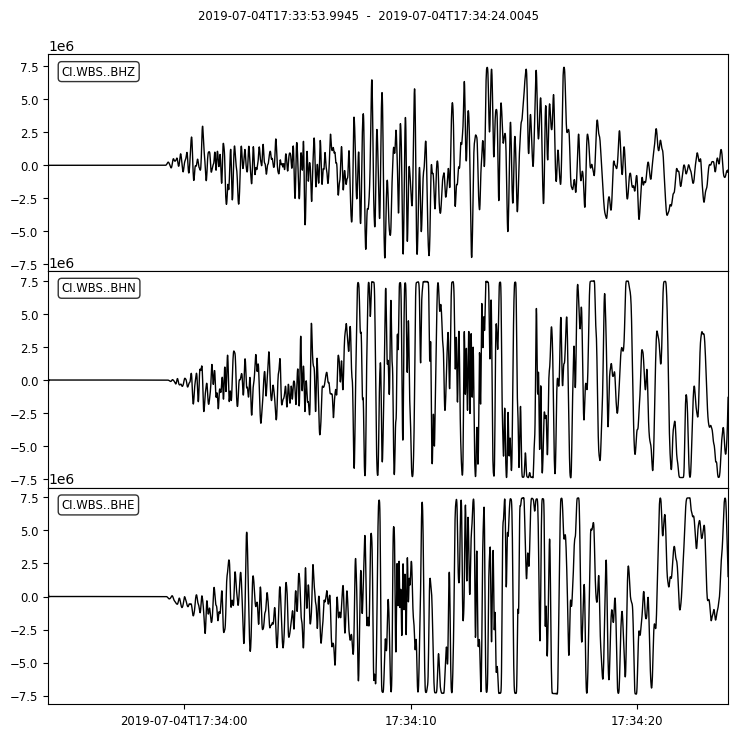

In [3]:
import obspy
from obspy.clients.fdsn import Client as FDSN_Client

# Connect to the FDSN client (in this case USGS)
client = FDSN_Client("SCEDC")

# Get the Ridgecrest earthquake from USGS ComCat
t1 = obspy.UTCDateTime("2019-07-04T00:00:00")
t2 = obspy.UTCDateTime("2019-07-05T00:00:00")

cat = client.get_events(starttime=t1, endtime=t2, minmagnitude=5, minlatitude=35, maxlatitude=36, minlongitude=-118, maxlongitude=-117, includearrivals=True)
event = cat[0]

# Get origin time of the event
origin_time = event.origins[0].time

# Define start and end time for the waveform retrieval
starttime = origin_time + 5  # Some seconds after the event
endtime = starttime + 30  # Total 30 seconds of data

# Network and station information
net = "CI"
sta = "WBS"

# Get the three-component data
st = client.get_waveforms(network=net, station=sta, location="*", channel="BH?", starttime=starttime, endtime=endtime)

station_picks = []
# Fetch the P and S picks
for pick in event.picks:
    if pick.waveform_id.station_code == sta:
        station_picks.append(pick)

# Make sure that sampling rate is 100Hz
st.resample(100);
# Plot the data
st.plot();

## How to use PhaseHunter

In [6]:
predictions = model.process_continuous_waveform(st)
predictions

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.94it/s]


## How to use PhaseHunter (advanced)

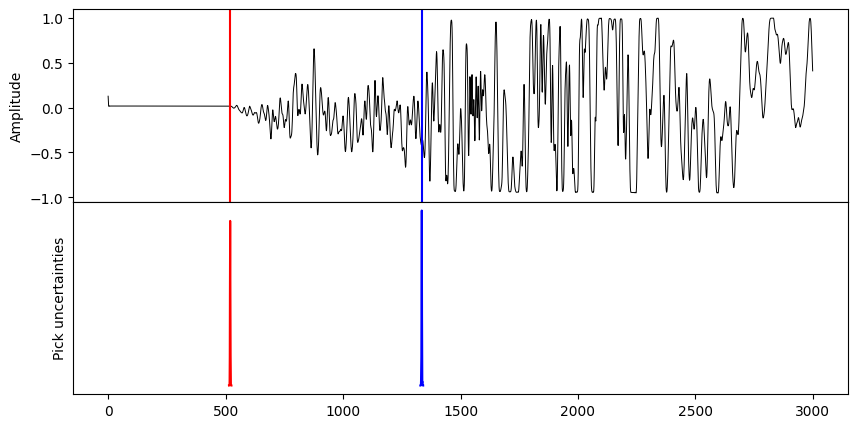

In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Convert stream into torch tensor
input_data = np.vstack([x.data for x in st])

# Preprocess data
demean_data = Augmentations().demean(input_data)
normalized_data = Augmentations().normalize(demean_data)

# Make sure that segment is 30s
cropped_data = normalized_data[:,:3000]

# Convert to tensor
tensor_data = torch.tensor(cropped_data, dtype=torch.float32)

# Now, for uncertainty estimation we need to create a batched copy of the input
inference_sample = torch.stack([tensor_data]*128).to(device)

# Make predictions
predictions, embeddings = model(inference_sample)

# Post process predictions
p_pred = predictions[:,0].detach().cpu()
s_pred = predictions[:,1].detach().cpu()
embeddings = torch.mean(embeddings, axis=0).detach().cpu().numpy()

# Estimate uncertainty and get the most likely values 
p_dist, p_kde, p_val, p_uncert = model.get_likely_val(p_pred)
s_dist, s_kde, s_val, s_uncert = model.get_likely_val(s_pred)

# Plot results
fig, ax = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

ax[0].plot(cropped_data[0], lw=0.7, color='black')
ax[0].axvline(p_val.item()*cropped_data.shape[-1], color='red', label='P pick')
ax[0].axvline(s_val.item()*cropped_data.shape[-1], color='blue', label='S pick')
ax[0].set_ylabel('Amplitude')

ax[1].plot(p_dist*cropped_data.shape[-1], p_kde(p_dist)*cropped_data.shape[-1], color='red')
ax[1].plot(s_dist*cropped_data.shape[-1], s_kde(s_dist)*cropped_data.shape[-1], color='blue')
ax[1].set_yticks([])
ax[1].set_ylabel('Pick uncertainties')

plt.subplots_adjust(hspace=0)